# C-MAPSS Anomaly Detection Variational Autoencoder

Como ya vimos en el workshop anterior, la detección de anomalías (Anomaly Detection) sobre sistemas con una alta dimensionalidad de datos, es un problema de particular interés en la operación y mantenimiento de activos. En particular, implementamos un Autoencoder sobre las series temporales nominales de CMAPSS con la finalidad de reconocer patrones o colecciones de datos que escapan del estado nominal del sistema analizado, i.e `anomalies`.

Ahora, si bien los Autoencoders son capaces de reducir la dimensionalidad de una determinada estructura de datos a un vector latente mediante su etapa de `encoding`, estos tienen el problema de que finalmente procesan o codifican cada sample de manera independiente. En otras palabras, si dos vectores latentes generados por el `encoder` son similares, esto no garantiza que sus reconstrucciones sean similares, por lo que la representación del vector latente pasa a ser parte de la caja negra del autoencoder. En este sentido, considerando que todos los datos o samples utilizados para el `training` del modelo son de la misma clase o describen el mismo sistema, nos gustaría que el `encoding` del vector latente sea capaz de capturar la distribución de los datos en su nueva representación.

<img src="https://miro.medium.com/max/1000/0*uq2_ZipB9TqI9G_k" width="600">

Aquí es donde entran los Variational Autoencoders (VAE) en los cuales, en términos generales, se impone (forzadamente) una distribución normal sobre cada uno de los componentes del vector latente. De este modo, como la distribución normal $\mathcal{N}(0, \sigma^2)$ se caracteriza por el promedio y la varianza de la distribución, la arquitectura VAE contiene estructuras que calculan y regulan estos parámetros.

## C-MAPSS Dataset

Como recordatorio, el C-MAPSS dataset que utilizaremos en esta ocación consiste en múltiples simulaciones de degradación de motores turbofán bajo distintas condiciones, tanto mecánicas como operacionales. En este sentido, el dataset se compone de más de `27000` series temporales de los sensores del turbofán que, gracias a la simulación de este, han podido ser asociadas al RUL del motor.

En esta sección nos encargaremos de cargar y explorar el dataset que utilizaremos, denominado `C-MAPSS FD001`, que contiene `100` simulaciones de motores mecánicamente distintos bajo condiciones nominales de operación. Nuevamente, para facilitar la carga del dataset a este entorno de Google Colab el achivo `CMAPSS_FD001.npz` ha sido cargado a un Google Drive.

In [ ]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('CMAPSS_FD001.npz', '1DNJFrQKB4I7SqjpFmM5SsKRaN7O9XCNZ')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

Carguemos este archivo mediante `np.load()` y exploremos las estructuras y datos que contiene.

In [ ]:
import numpy as np

# cargar archivo CMAPSS_FD001.npz
dataset = np.load('/content/datasets/CMAPSS_FD001.npz', allow_pickle=True)

# print keys del dataset
print(  list( dataset.keys() ) )

También, como ya es rutinario, aprovecharemos de cargar el GitHub del curso deeplearningfallas para disponer de algunas utilidades que nos serán de utilidad más adelante.

In [ ]:
# cargar GitHub https://github.com/cherrerab/deeplearningfallas.git
%cd /content/
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

---
# Training Data

Como ya sabemos, el dataset se encuentra previamente separado en conjuntos de `training` y `testing`. En particular, cada uno de estos conjuntos están separados en `100` simulaciones de turbinas distintas. Luego, cada una de estas simulaciones contiene varias muestras de series temporales registradas durante la operación que están asociadas a un valor RUL en el conjunto `Y_train` o `Y_test`.

Nuevamente, para generar los conjuntos `training` y `testing` que finalmente utilizaremos para desarrollar nuestros modelos, debemos concatenar las series de todas las simulaciones de `C-MAPSS` y modificar sus dimensiones para que sean compatibles con las capas y estructuras de `tensorflow` y `keras`. En particular, recordemos que los datos de cada simulación en el conjunto `X_train` son de la forma `(n_samples, n_timesteps, n_features, 1)`. Donde en este caso `n_features` corresponde a la cantidad de sensores dentro de la simulación (`14`), mientras `n_timesteps` corresponde a la cantidad de puntos temporales o mediciones dentro de la serie (`30`). Por otro lado, los datos del conjunto `Y_train` son de la forma `(n_samples, 1)`, donde cada valor corresponde al RUL de las respectivas series temporales en el conjunto `X_train`.

En este caso, a diferencia del workshop anterior, aplanaremos las series temporales de cada sample en un único vector de la forma `(n_timesteps*n_features, )`, pues consideraremos cada punto dentro del registro temporal como una dimensión que define el espacio vectorial de nuestra colección de datos.

In [ ]:
# extraer conjuntos de training y testing del dataset
X_train, Y_train = dataset['x_train'], dataset['y_train']
X_test, Y_test = dataset['x_test'], dataset['y_test']

# ---
# concatenar y reconfigurar datos de las 100 simulaciones CMAPSS
# en este caso reordenaremos cada sample de la forma (n_timesteps*n_features)
# para ingresarlos al autoencoder que desarrollaremos.

# los datos X deben ser de la forma (n_samples, n_timesteps*n_features)
X_train = np.vstack( X_train )
X_train = np.reshape( X_train, (-1, 30*14) )

X_test = np.vstack( X_test )
X_test = np.reshape( X_test, (-1, 30*14) )

# los datos Y deben ser de la forma (n_samples, 1)
Y_train = np.vstack( Y_train )
Y_train = np.reshape( Y_train, (-1, 1) )

Y_test = np.vstack( Y_test )
Y_test = np.reshape( Y_test, (-1, 1) )

# print dimensiones de los nuevos conjuntos
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('\nX_test.shape: ', X_test.shape)
print('Y_test.shape: ', Y_test.shape)


Ahora, como se mencionó en la introducción de este workshop, para el entrenamiento del `autoencoder` que desarrollaremos utilizaremos únicamente datos o `samples` que presenten una condición `nominal` de operación. Arbitrariamente definirimos esta condición en función del RUL de cada sample, donde aquellos que presenten un RUL menor a 0.3, se encontrarán en un estado de degradación.

In [ ]:
# ---
# segementar samples que presenten una serie temporal de operación 'nominal'
# en este caso, un sample 'nominal' es aquel cuyo RUL > 0.3

# obtener indices nominal_idx de samples nominales
# mediante np.where
RUL_train = Y_train.flatten() 
nominal_idx = np.where( RUL_train > 0.3 )[0]

# segementar X_train con samples nominales
X_train_nominal = X_train[nominal_idx, :]

# print dimensiones de este nuevo conjunto
print('X_train_nominal.shape: ', X_train_nominal.shape)

Como tenemos una gran cantidad de datos tanto en el conjunto de `training`, como en el de `testing`, siguiendo el procedimiento apropiado para el desarrollo de modelos de deep learning, utilizaremos la función `sklearn.train_test_split` para generar un conjunto de `validation`.

In [ ]:
from sklearn.model_selection import train_test_split

# ---
# realizar data splitting para generar los conjuntos (X_train_AE, X_val_AE)
# para el entrenamiento del autoencoder.

# dado que los autoencoders son modelos de reeconstrucción, en este caso
# no es necesario extraer conjuntos Y.
X_train_AE, X_val_AE, _, _ = train_test_split(X_train_nominal, X_train_nominal,
                                              train_size=0.8 , test_size=0.2 ,
                                              random_state=217 )

# print sample distribution
print( 'train split: {:d} samples'.format(X_train_AE.shape[0]) )
print( '\nvalidation split: {:d} samples'.format(X_val_AE.shape[0]) )

---
# Model Building

Ahora comenzaremos a implementar el `variational autoencoder` en que se centra el trabajo de este workshop. Finalmente, un `variational autoencoder` no es un muy diferente del `vanilla autoencoder` en cuanto a la estructura general de `encoder` y `decoder`. No obstante, las VAE incorporan estructuras que se encargan de realizar un `random sampling` sobre la distribución normal para generar el vector latente.

Para esto, los `variational autoencoder` incorporan dos capas `Dense` paralelas que representan el `mu` y la `log_variance` del sample procesado. Luego, estas dos representaciones son utilizadas para realizar el `random sampling` y generar el `latent_vector` mediante una función predefinida `normal_random_sampling`.

In [8]:
import keras.backend as kb


def normal_random_sampling(mu_log_variance):
  """
  -> np.array

  extrae el vector latente de la distribución normal (multidimensional) descrita
  por los parámetros mu, log_variance = mu_log_variance

  :param tuple(np.array) mu_log_variance:
    tupla que contiene los vectores mu y log_variance del sample.

  :returns:
    random sample sobre la distribución normal definida por estos parámetros.
  """

  # extraer parámetros
  mu, log_variance = mu_log_variance

  # obtener random sample sobre la distribución normal estándar
  epsilon = kb.random_normal(shape=kb.shape(mu), mean=0.0, stddev=1.0)

  # ajustar random sample a la distribución N(mu, var)
  random_sample = mu + kb.exp(log_variance/2) * epsilon
  
  return random_sample

## Model Setup

Para configurar nuestro modelo VAE, del mismo modo que como lo hicimos con el `vanilla autoencoder`, debemos definir separadamente los modelos `encoder` y `decoder` que lo compondrán. Similar a la figura de arriba, para configurar nuestro modelo de regresión utilizaremos nuevamente la librería `keras` o `tf.keras` y se compondrá principalmente de capas `Dense`, también llamadas Fully Connected en la literatura.

- https://keras.io/api/layers/core_layers/dense/

De esta forma, en términos generales, compondremos nuestro `encoder` de una serie de capas `Dense`, que se encargarán de procesar la información y los features de los datos de entrada hasta dos capas `Dense` `encoder_mu` y `encoder_log_var` que serán luego ingresadas a la función `normal_random_sampling`, mediante una capa `Lambda`, para generar el `latent_vector`. De la misma manera, ya sea simétricamente o no, el `decoder` recibirá como entrada el `latent_vector` y mediante otra serie de capas `Dense` reconstruirá los datos originales.

In [9]:
import keras
from keras.models import Model
from keras.layers import Input

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda

from keras.utils import plot_model

# en este caso crearemos el autoencoder usando la API Functional
# la API Functional de keras permite la creación de modelos de una
# manera mucho más flexible
# https://keras.io/guides/functional_api/

# ---
# primero debemos crear nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
# en este caso el autoencoder recibe samples de la forma (420, )
input_dim = ( 420, )
input_layer = Input( shape=input_dim )

# ---
# ahora debemos ir agregando nuestras capas Dense para configurar
# el modelo encoder.
# https://keras.io/api/layers/core_layers/dense/

encoder = Dense(units=256, activation='relu')(input_layer)
encoder = Dense(units=128, activation='relu')(encoder)

encoder = Dropout(rate=0.1)(encoder)

encoder = Dense(units=128, activation='relu')(encoder)
encoder = Dense(units=128, activation='relu')(encoder)

# ahora configuraremos el par de capas Dense que representarán
# el mu y el log_variance del sample.
# estas deben poseer la misma dimensión que el vector latente.
latent_dim = 128
encoder_mu = Dense(units=latent_dim, activation='linear')(encoder)
encoder_log_var = Dense(units=latent_dim, activation='linear')(encoder)

# utilizando una capa keras.Lambda podemos ingresar estos dos vectores
# a la función normal_random_sampling y considerar este cálculo como
# otra etapa en la arquitectura.
# las keras.Lambda están diseñadas justamente para incorporar funciones
# arbitrarias o personalizadas dentro de los modelos
# https://keras.io/api/layers/core_layers/lambda/
latent_vector = Lambda(normal_random_sampling)( [encoder_mu, encoder_log_var] )

# finalmente, debemos ir agregando nuestras capas Dense para configurar
# el decoder de nuestro modelo.
# en este caso hay que tener presente que la salida de esta sección
# debe tener la misma dimensionalidad o forma que los samples de entrada.

decoder = Dense(units=128, activation='relu')(latent_vector)
decoder = Dense(units=128, activation='relu')(decoder)

decoder = Dropout(rate=0.1)(decoder)

decoder = Dense(units=128, activation='relu')(decoder)
decoder = Dense(units=256, activation='relu')(decoder)

output_layer = Dense(units=420, activation='linear')(decoder)

# ---
# ahora configuraremos el modelo autoencoder que entrenaremos
VAE_model = Model(input_layer, output_layer)

# adicionalmente podemos configurar el modelo encoder
# para utilizarlo como un reductor dimensional
# esto resulta más práctico cuando la dimensión es 2 o 3
encoder_model = Model(input_layer, latent_vector)

# print model.summary()
VAE_model.summary()

# generar diagrama del modelo
_ = plot_model(VAE_model, to_file='/content/model.png', show_shapes=True, show_layer_names=False )

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 420)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          107776      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           dense_1[0][0]                    
_______________________________________________________________________________________

## Compile Model

Como siempre, antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/


En este caso, a diferencia del `vanilla autoencoder` visto en el workshop anterior, los `variational autoencoders` no solo deben ser entrenados para reducir el error de reconstrucción, sino que como la idea es también imponer que cada uno de los componentes del vector latente siga una distribución normal estándar, este factor también debe ser incorporado en la función de pérdida. De este modo, debemos definir una función de pérdida personalizada para este caso particular.

In [10]:
import keras.backend as kb

def loss_VAE(encoder_mu, encoder_log_var):
  """
  -> float

  función de pérdida para el entrenamiento de los variational autoencoders,
  esta se compone de un factor de reconstrucción (vae_reconstruction_loss)
  y otro correspondiente a la divergencia KL entre la distribución dada por
  las capas encoder_mu y encoder_log_var, y la distribución normal estándar.
  """

  def vae_reconstruction_loss(y_true, y_predict):
    """
    error mse de reconstrucción.
    """
    # ponderación del error de reconstrucción
    reconstruction_loss_factor = 1000

    # error cuadrado medio de reconstrucción
    reconstruction_loss = kb.mean(kb.square(y_true-y_predict), axis=1)

    return reconstruction_loss_factor * reconstruction_loss

  def vae_kl_loss(encoder_mu, encoder_log_variance):
    """
    error de divergencia Kullback-Leibler.
    la divergencia Kullback–Leibler cuantifica que tan diferente es una
    distribución probabilística respecto a otra.
    """
    kl_loss = -0.5 * kb.sum(1.0 + encoder_log_variance - kb.square(encoder_mu) - kb.exp(encoder_log_variance), axis=1)
    return kl_loss

  def vae_kl_loss_metric(y_true, y_predict):
    """
    error de divergencia Kullback-Leibler.
    la divergencia Kullback–Leibler cuantifica que tan diferente es una
    distribución probabilística respecto a otra.
    """
    kl_loss = -0.5 * kb.sum(1.0 + encoder_log_variance - kb.square(encoder_mu) - kb.exp(encoder_log_variance), axis=1)
    return kl_loss

  def vae_loss(y_true, y_predict):
    """
    ponderación final del error de reconstrucción y la divergencia KL.
    """
    # error de reconstrucción
    reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)

    # divergencia kullback-leibler.
    kl_loss = vae_kl_loss(y_true, y_predict)

    # retornar loss
    loss = reconstruction_loss + kl_loss
    return loss

  return vae_loss

In [11]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam( learning_rate=1e-3 )

# ---
# compilar modelo siguiendo como función de pérdida
# en este caso, usaremos el error cuadrádo medio (mse)
VAE_model.compile( loss=loss_VAE(encoder_mu, encoder_log_var), optimizer=opt )

## Model Training
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

En este caso, es necesario especificar que los datos `Y_train` del entrenamiento son equivalentes a los datos de entrada `X_train`.

Epoch 1/150
37/37 [==============================] - 1s 26ms/step - loss: 93.0340 - val_loss: 64.4074
Epoch 2/150
37/37 [==============================] - 1s 21ms/step - loss: 61.8638 - val_loss: 59.4335
Epoch 3/150
37/37 [==============================] - 1s 22ms/step - loss: 59.8798 - val_loss: 59.3448
Epoch 4/150
37/37 [==============================] - 1s 21ms/step - loss: 59.4968 - val_loss: 59.9027
Epoch 5/150
37/37 [==============================] - 1s 21ms/step - loss: 59.3221 - val_loss: 60.0492
Epoch 6/150
37/37 [==============================] - 1s 21ms/step - loss: 59.1621 - val_loss: 59.8101
Epoch 7/150
37/37 [==============================] - 1s 21ms/step - loss: 59.0765 - val_loss: 59.6939
Epoch 8/150
37/37 [==============================] - 1s 22ms/step - loss: 58.9244 - val_loss: 59.5844
Epoch 9/150
37/37 [==============================] - 1s 21ms/step - loss: 58.8538 - val_loss: 59.9555
Epoch 10/150
37/37 [==============================] - 1s 21ms/step - loss: 58.7774

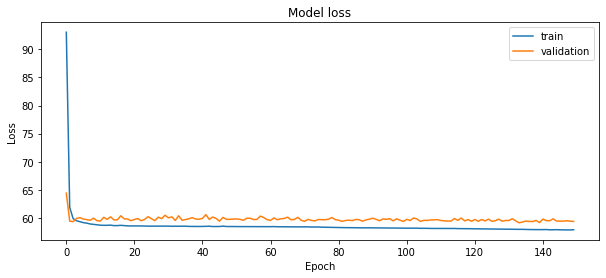

In [12]:
from utils import plot_loss_function

# realizar rutina de entrenamiento
train_history = VAE_model.fit(X_train_AE, X_train_AE,
                              batch_size=256, epochs=150,
                              validation_data=(X_val_AE, X_val_AE))

# plot gráfico de función de pérdida
plot_loss_function(train_history, figsize=(10,4))

## Model Evaluation

Ahora, recordemos que la razón incial del desarrollo de este autoencoder es analizar si este puede ser utilizado para segementar o bien, permitir el reconocimiento de series temporales que presenten un estado de degradación crítico. De este modo, evaluaremos si existe una diferencia significativa entre el error de reconstrucción sobre los datos `nominales` y los `degradados`. Para emplear el `variational autoencoder` sobre nuevas series temporales, conviene utilizar el método `keras.Model.predict`, análogamente a como hemos hecho en las arquitecturas anteriores.

Por otro lado, dado que estamos frente a un problema de regresión no podemos utilizar las herramientas de visualización anteriores como la matriz de consfusión. En este caso utilizaremos un `scatter plot` medainte la función `utils.plot_predict_scatter` para visualizar la correlación entre las predicciones `Y_pred` y los valores reales `Y_true`.

In [13]:
from utils import plot_predict_scatter

# ---
# obtener predicciones de X_test del modelo
# en primer lugar, similar a como hicimos para X_train
# debemos segmentar las series nominales de las degradadas.

# obtener indices nominal_idx de samples nominales
RUL_test = Y_test.flatten() 
nominal_idx = np.where( RUL_test > 0.3 )[0]
degraded_idx = np.where( RUL_test <= 0.3 )[0]

# segementar samples nominales y degradados
X_test_nominal = X_test[nominal_idx, :]
X_test_degraded = X_test[degraded_idx, :]

# obtener recontrucciones del autoencoder
AE_test_nominal = VAE_model(X_test_nominal)
AE_test_degraded = VAE_model(X_test_degraded)

# obtener el rmse de las reconstrucciones
rmse_nominal = np.sqrt( np.mean( np.power(X_test_nominal - AE_test_nominal, 2 ), axis=1) )
rmse_degraded = np.sqrt( np.mean( np.power(X_test_degraded - AE_test_degraded, 2 ), axis=1) )

print('nominal rmse: {:1.3f}'.format(np.mean(rmse_nominal)))
print('degraded rmse: {:1.3f}'.format(np.mean(rmse_degraded)))

nominal rmse: 0.167
degraded rmse: 0.168


De esta manera, podemos ver que dentro del conjunto de series temporales degradadas existen puntos que escapan significativamente del rango de rmse. Podemos detectar o bien, asilar estos puntos definiendo un umbral o `threshold`.

detected anomalies:  258
accuracy: 21.36%


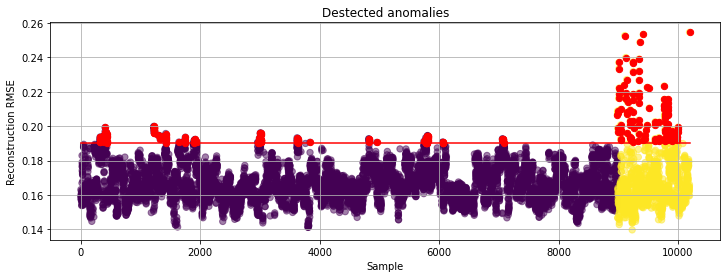

In [14]:
import matplotlib.pyplot as plt

# ---
# obtener predicciones sobre todo el test set
AE_test = VAE_model(X_test)
rmse_test = np.sqrt( np.mean( np.power(X_test - AE_test, 2 ), axis=1) )

# sort test samples para segmentar grupos nominales y degradados
sample_label = np.array( RUL_test <= 0.3, dtype=int )
sample_sort = np.argsort(sample_label)

sample_label = sample_label[sample_sort]
rmse_test = rmse_test[sample_sort]

# umbral de rmse
threshold = 0.19

# obtener sample que superen el umbral
anomalies = np.where(rmse_test > threshold)[0]

accuracy = 100*anomalies.size/degraded_idx.size

# print cantidad de anomalias detectadas
print('detected anomalies: ', anomalies.size)
print('accuracy: {:2.2f}%'.format(accuracy))

# ---
# visualizar en scatter plot
plt.figure( figsize=(12, 4) )
plt.title('Destected anomalies')
plt.xlabel('Sample'); plt.ylabel('Reconstruction RMSE')

plt.scatter(np.arange(rmse_test.size), rmse_test,
            c=list(sample_label), cmap='viridis', alpha=0.5, s=40)

plt.scatter(anomalies, rmse_test[anomalies], c='r', s=40)
plt.plot([0, rmse_test.size], [threshold, threshold], c='r')
plt.grid(True)

# Curva ROC

La curva ROC o `Receiver Operating Characteristic` es una representación gráfica de la variación de la sensibilidad de un clasificador binario, respecto a su especificidad, al variar el umbral de discriminación o `threshold`.

Recordemos que en un clasificador binario, la sensibilidad corresponde al accuracy de `Verdaderos Positivos (TP)`, mientras que la especificidad corresponde al accuracy de `Verdaderos Negativos (TN)`.

$Sensibilidad = \frac{TP}{TP + FN}$

$Especificidad = \frac{TN}{TN + FP}$

Analizar la curva ROC de un clasificador, permite por un lado evaluar la calidad del clasificador, como también seleccionar el umbral apropiado para la aplicación. Recordar que el umbral siempre dependerá del costo particular que tengan los `Falsos Positivos` y los `Falsos Negativos`. A continuación se define una función que genera la curva ROC en base al `autoencoder` que le entreguemos.

AUC: 0.4748


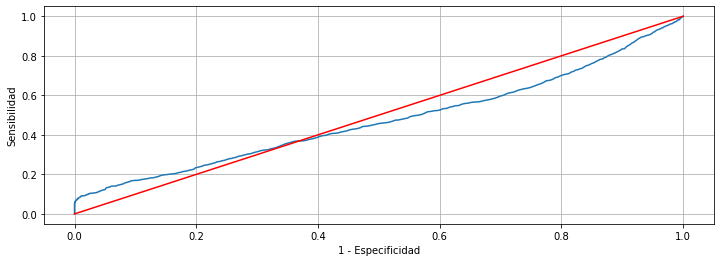

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def generate_ROC(X, Y, autoencoder):
  """
  -> None

  genera y gráfica la curva Receiver Operating Characteristic sobre el detector
  de anomalías dado por el modelo autoencoder entregado.

  :param np.array X:
    datos a clasificar mediante el detector de anomalías.
  :param np.array Y:
    etiquetas reales de los datos X.
  :param keras.model autoencoder:
    modelo a partir del cual se construye el detector de anomalías.

  :returns:
    gráfico ROC.
  """

  # obtener indices nominal_idx de samples nominales
  # ** esto es específico para este caso de estudio **
  RUL = Y_test.flatten() 
  nominal_idx = np.where( RUL > 0.3 )[0]
  degraded_idx = np.where( RUL <= 0.3 )[0]

  # segementar samples nominales y degradados
  X_nominal = X[nominal_idx, :]
  X_degraded = X[degraded_idx, :]

  # obtener reconstrucciones mediante el autoencoder
  AE_nominal = autoencoder(X_nominal)
  AE_degraded = autoencoder(X_degraded)

  # obtener rmse de reconstrucciones
  rmse_nominal = np.sqrt( np.mean( np.power(X_nominal - AE_nominal, 2 ), axis=1) )
  rmse_degraded = np.sqrt( np.mean( np.power(X_degraded - AE_degraded, 2 ), axis=1) )

  # ---
  # generar curva ROC
  min_rmse = np.min( np.hstack([rmse_nominal, rmse_degraded]), axis=None )
  max_rmse = np.max( np.hstack([rmse_nominal, rmse_degraded]), axis=None )
  threshold = np.linspace(min_rmse, max_rmse, 1000)

  S, R = [], []
  # para cada umbral en el rango threshold
  for t in threshold:
    # obtener sensibilidad (True Positives/All Positives)
    anomalies = np.where(rmse_degraded > t)[0]
    sensibilidad = anomalies.size/degraded_idx.size

    # obtener ratio (False Positives/All Negatives)
    anomalies = np.where(rmse_nominal > t)[0]
    ratio = anomalies.size/nominal_idx.size

    # registrar valores en listas
    S.append(sensibilidad)
    R.append(ratio)

  # print AUC
  area = auc(R, S)
  print('AUC: {:1.4f}'.format(area))

  # visualizar
  plt.figure( figsize=(12, 4) )
  plt.plot(R, S)

  plt.plot([0, 1], [0, 1], 'r')
  plt.xlabel('1 - Especificidad')
  plt.ylabel('Sensibilidad')
  plt.grid(True)
  plt.show()


# generar curva ROC sobre los X_test
generate_ROC(X_test, Y_test, VAE_model)

